In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load raw data
url = "https://data.insideairbnb.com/thailand/central-thailand/bangkok/2025-09-26/data/listings.csv.gz"
df_list = pd.read_csv(url, compression="gzip")
#df_list.head(2)

In [3]:
# 2. CLEAN PRICE COLUMN
# drop na
df_list = df_list.dropna(subset=['price'])
df_list.info() # 23273 entries

<class 'pandas.core.frame.DataFrame'>
Index: 23273 entries, 0 to 28805
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23273 non-null  int64  
 1   listing_url                                   23273 non-null  object 
 2   scrape_id                                     23273 non-null  int64  
 3   last_scraped                                  23273 non-null  object 
 4   source                                        23273 non-null  object 
 5   name                                          23273 non-null  object 
 6   description                                   22837 non-null  object 
 7   neighborhood_overview                         7477 non-null   object 
 8   picture_url                                   23273 non-null  object 
 9   host_id                                       23273 non-null  int6

In [4]:
df_list['price'] = (df_list['price'].astype(str).str.replace(r'[^0-9.]', '', regex=True).replace('', np.nan).astype(float))

In [ ]:
print(df_list['price'].describe().to_string())

count      23273.000000
mean        2528.749151
std        16473.896035
min            4.000000
25%          923.000000
50%         1379.000000
75%         2207.000000
max      1000000.000000


In [5]:
# keep price between 100 and 20,000 THB (reasonable range for nightly rentals)

df_list = df_list[(df_list['price'] > 0) & 
                  (df_list['price'] >= 100) & 
                  (df_list['price'] <= 20000)].copy()

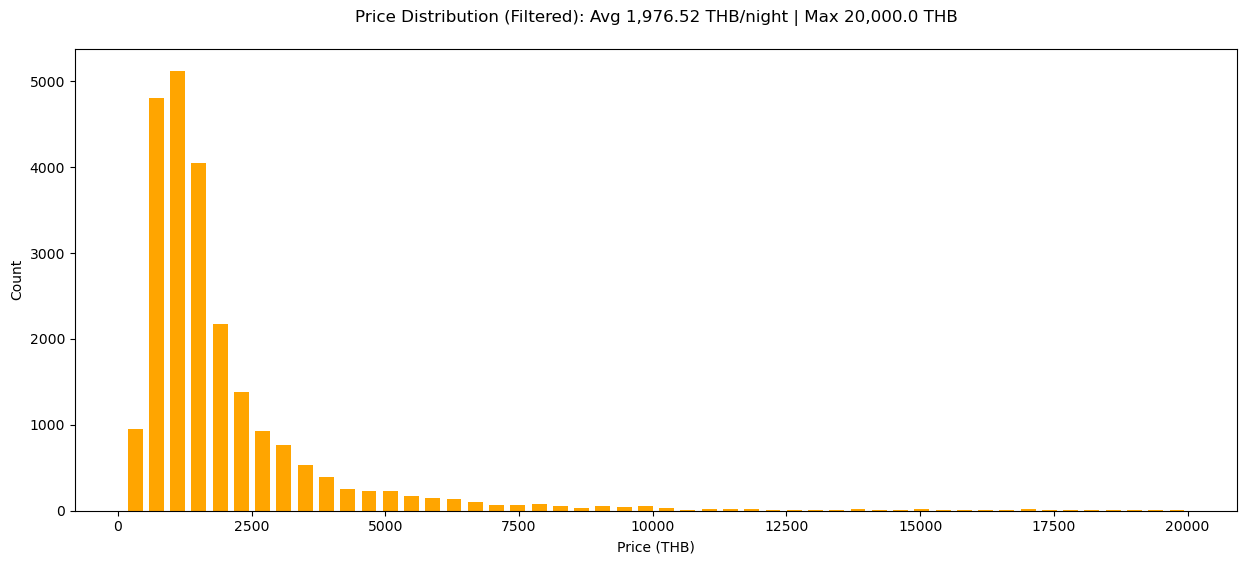

In [8]:
# Plot prices AFTER filtering
prices = df_list['price']
prices = prices[prices > 0]

plt.figure(figsize=(15, 6))
plt.title(f"Price Distribution (Filtered): Avg {prices.mean():,.2f} THB/night | Max {prices.max():,} THB\n")
plt.xlabel("Price (THB)")
plt.ylabel("Count")

plt.hist(prices, rwidth=0.7, color="orange", bins=50)

plt.show()

In [9]:
# load review data
url = "https://data.insideairbnb.com/thailand/central-thailand/bangkok/2025-09-26/data/reviews.csv.gz"
df_review = pd.read_csv(url, compression="gzip")
# df_review.head()

In [10]:
# long to wide convert
# 3. AGGREGATE REVIEWS → ONE TEXT PER LISTING
grouped = df_review.groupby('listing_id')['comments'].apply(lambda texts: " ".join(texts.dropna().astype(str))).reset_index()
grouped.rename(columns={'comments':'all_review_texts'}, inplace=True)

# Merge listings + aggregated reviews
df = df_list.merge(grouped, how='left', left_on='id', right_on='listing_id')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23273 entries, 0 to 23272
Data columns (total 81 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23273 non-null  int64  
 1   listing_url                                   23273 non-null  object 
 2   scrape_id                                     23273 non-null  int64  
 3   last_scraped                                  23273 non-null  object 
 4   source                                        23273 non-null  object 
 5   name                                          23273 non-null  object 
 6   description                                   22837 non-null  object 
 7   neighborhood_overview                         7477 non-null   object 
 8   picture_url                                   23273 non-null  object 
 9   host_id                                       23273 non-null 

In [ ]:
#----START FROM HERE-----------------------

In [12]:
# join listing text
TEXT_COLS = [
    "name",
    "description",
    "neighborhood_overview",
    "amenities",
    "property_type",
    "room_type",
    "bathrooms_text",
    "host_about"
]

def combine_listing_text(row):
    parts = []
    for col in TEXT_COLS:
        val = row.get(col, "")
        if isinstance(val, str) and val.strip():
            parts.append(val.strip())
    return " ".join(parts)

df["listing_text"] = df.apply(combine_listing_text, axis=1)


In [13]:
# combine
def build_final_text(row):
    review = row.get("all_review_texts", "")
    listing = row.get("listing_text", "")

    if isinstance(review, str) and review.strip():
        return review + " " + listing
    else:
        return listing

df["final_text"] = df.apply(build_final_text, axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23092 entries, 0 to 23091
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23092 non-null  int64  
 1   listing_url                                   23092 non-null  object 
 2   scrape_id                                     23092 non-null  int64  
 3   last_scraped                                  23092 non-null  object 
 4   source                                        23092 non-null  object 
 5   name                                          23092 non-null  object 
 6   description                                   22659 non-null  object 
 7   neighborhood_overview                         7445 non-null   object 
 8   picture_url                                   23092 non-null  object 
 9   host_id                                       23092 non-null 

In [15]:
#-----------------------------------------------------------------------------------------------
# TEXT CLEANING
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)

    # Remove <br>, <br/>, <BR>, <br /> etc.
    text = re.sub(r'<\s*br\s*/?\s*>', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)  # Remove other HTML tags

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove emojis and non-ASCII characters
    text = text.encode('ascii', 'ignore').decode()

    # Clean special characters but keep basic punctuation
    text = re.sub(r'[:\[\]"{}""'']+', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Clean up comma issues
    text = text.replace(" ,", ",").replace(",,,", ",").replace(",,", ",")

    return text

df["final_text_clean"] = df["final_text"].apply(clean_text)

In [16]:
df_phase2 = df[
    (df["price"] > 0) &
    (df["final_text"].str.len() > 50)
].copy()

print(df_phase2.shape)

(23092, 84)


In [ ]:
df.iloc[10].to_dict()

In [17]:
# Save
df_phase2.to_pickle("df_phase2.pkl")

# NLP

In [18]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

# Core sklearn pipeline
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
y = np.log1p(df_phase2["price"])

In [20]:
## 1. Numeric feature preparation
# chỉ chọn features có ý nghĩa kinh tế
NUMERIC_COLS = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "latitude",
    "longitude"
]

df_num = df_phase2[NUMERIC_COLS].copy()

In [21]:
# numeric process pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [22]:
## 2. text data
texts = df_phase2["final_text_clean"].values

In [23]:
X_num_train, X_num_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    df_num,
    texts,
    y,
    test_size=0.2,
    random_state=42
)

In [24]:
X_num_train_proc = numeric_pipeline.fit_transform(X_num_train)
X_num_test_proc  = numeric_pipeline.transform(X_num_test)

In [25]:
baseline_model = Ridge(alpha=1.0)
baseline_model.fit(X_num_train_proc, y_train)

y_pred = baseline_model.predict(X_num_test_proc)
mae_numeric = mean_absolute_error(
    np.expm1(y_test),
    np.expm1(y_pred)
)

print(f"Numeric only MAE: {mae_numeric:,.0f} THB")

Numeric only MAE: 884 THB


In [26]:
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=5
)

In [27]:
X_txt_train_tfidf = tfidf.fit_transform(X_txt_train)
X_txt_test_tfidf  = tfidf.transform(X_txt_test)

In [28]:
# combine numeric + text
from scipy.sparse import hstack

X_train_all = hstack([X_num_train_proc, X_txt_train_tfidf])
X_test_all  = hstack([X_num_test_proc,  X_txt_test_tfidf])

In [29]:
model_tfidf = Ridge(alpha=1.0)
model_tfidf.fit(X_train_all, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [30]:
y_pred = model_tfidf.predict(X_test_all)

mae_tfidf = mean_absolute_error(
    np.expm1(y_test),
    np.expm1(y_pred)
)

print(f"Numeric + TF-IDF MAE: {mae_tfidf:,.0f} THB")

Numeric + TF-IDF MAE: 592 THB
